In [1]:
import pandas as pd 
import numpy as np 
from numpy import sqrt
from matplotlib import pyplot
import itertools
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import datetime, time
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [2]:
airlines = pd.read_excel('Airlines+Data.xlsx')
airlines.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [3]:
airlines['Month'] = pd.to_datetime(airlines['Month'],infer_datetime_format = True)
indexedAirlines = airlines.set_index(['Month'])
airlines.head(3)

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132


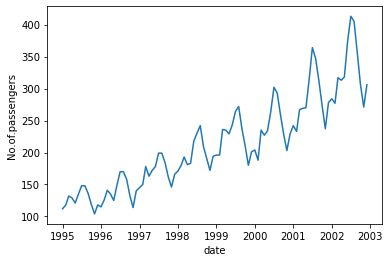

In [4]:
plt.xlabel("date")
plt.ylabel("No.of.passengers")
plt.plot(indexedAirlines)

In [5]:
rollmean = indexedAirlines.rolling(window=12).mean()

In [6]:
rollstd = indexedAirlines.rolling(window=12).std()
print(rollmean,rollstd)

            Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01  316.833333
2002-09-01  320.416667
2002-10-01  323.083333
2002-11-01  325.916667
2002-12-01  328.250000

[96 rows x 1 columns]             Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01   54.530781
2002-09-01   55.586883
2002-10-01   53.899668
2002-11-01   49.692616
2002-12-01   47.861780

[96 rows x 1 columns]


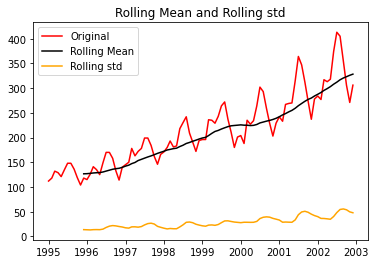

In [7]:
orig = plt.plot(indexedAirlines, color='red', label = 'Original')
mean = plt.plot(rollmean, color = 'black', label = 'Rolling Mean')
std = plt.plot(rollstd, color = 'orange', label = 'Rolling std')
plt.legend(loc = 'best')
plt.title('Rolling Mean and Rolling std')
plt.show(block=False)

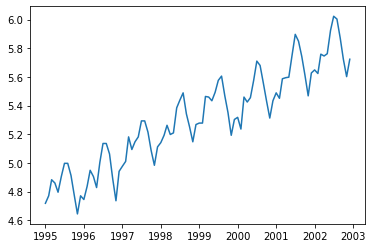

In [8]:
indexedAirlines_logScale = np.log(indexedAirlines)
plt.plot(indexedAirlines_logScale)


In [9]:
movingAverage = indexedAirlines_logScale.rolling(window=12).mean()
movingSTD = indexedAirlines_logScale.rolling(window=12).std()

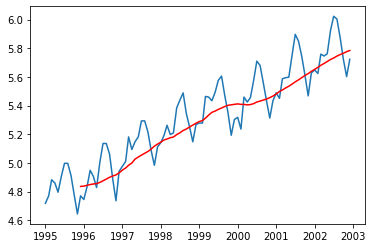

In [10]:
plt.plot(indexedAirlines_logScale)
plt.plot(movingAverage,color='red')

In [11]:
df = indexedAirlines_logScale - movingAverage
df.head(5)

,Passengers
Month,
1995-01-01,NaN
1995-02-01,NaN
1995-03-01,NaN
1995-04-01,NaN
1995-05-01,NaN


In [12]:
df.dropna(inplace = True)

In [13]:
df[:3]

,Passengers
Month,
1995-12-01,-0.065494
1996-01-01,-0.093449
1996-02-01,-0.007566


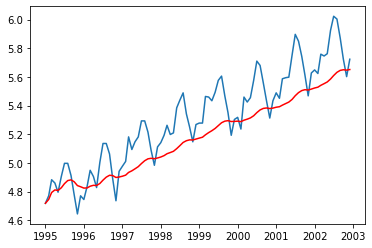

In [14]:
exponentialDecayWeightedAverage = indexedAirlines_logScale.ewm(halflife=12,min_periods=0,adjust=True).mean()
plt.plot(indexedAirlines_logScale)
plt.plot(exponentialDecayWeightedAverage, color = 'red')

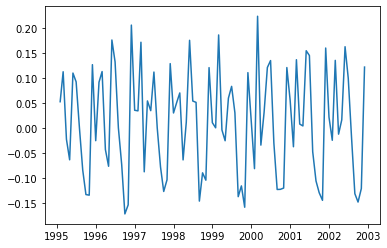

In [15]:
datasetLogScaleMinusMovingExponentDecayAverage = indexedAirlines_logScale-exponentialDecayWeightedAverage
datasetLogDiffShifting = indexedAirlines_logScale - indexedAirlines_logScale.shift()
plt.plot(datasetLogDiffShifting)

In [16]:
datasetLogDiffShifting[:3]

,Passengers
Month,
1995-01-01,NaN
1995-02-01,0.052186
1995-03-01,0.112117


In [17]:
datasetLogDiffShifting.dropna(inplace=True)
datasetLogDiffShifting[:3]

,Passengers
Month,
1995-02-01,0.052186
1995-03-01,0.112117
1995-04-01,-0.022990


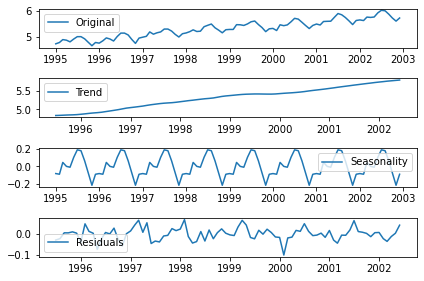

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedAirlines_logScale)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedAirlines_logScale, label = "Original")
plt.legend(loc = "best")

plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')

plt.subplot(413)
plt.plot(seasonal, label = 'Seasonality')
plt.legend(loc = 'best')

plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc = 'best')
plt.tight_layout()
decompositionLogData = residual
decompositionLogData.dropna(inplace=True)

In [19]:
from statsmodels.tsa.stattools import acf,pacf


In [20]:
acf = acf(datasetLogDiffShifting, nlags = 20)
pacf = pacf(datasetLogDiffShifting, nlags = 20, method = 'ols')

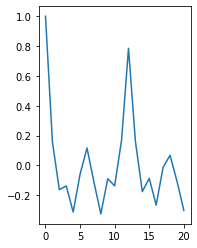

In [21]:
plt.subplot(121)
plt.plot(acf)

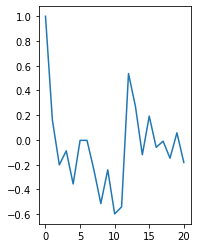

In [22]:
plt.subplot(122)
plt.plot(pacf)

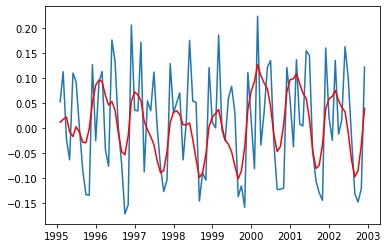

In [23]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(indexedAirlines_logScale, order= (2,1,2))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.show()

In [24]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues,copy = True)

In [25]:
predictions_ARIMA_diff

Month
1995-02-01    0.011261
1995-03-01    0.016606
1995-04-01    0.021673
1995-05-01   -0.008098
1995-06-01   -0.017404
                ...   
2002-08-01   -0.064372
2002-09-01   -0.097877
2002-10-01   -0.085698
2002-11-01   -0.033980
2002-12-01    0.038843
Length: 95, dtype: float64

In [26]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum

Month
1995-02-01    0.011261
1995-03-01    0.027867
1995-04-01    0.049540
1995-05-01    0.041442
1995-06-01    0.024038
                ...   
2002-08-01    0.954121
2002-09-01    0.856245
2002-10-01    0.770547
2002-11-01    0.736567
2002-12-01    0.775411
Length: 95, dtype: float64

In [27]:
predictions_ARIMA_log = pd.Series(indexedAirlines_logScale['Passengers'].iloc[0], index = indexedAirlines_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

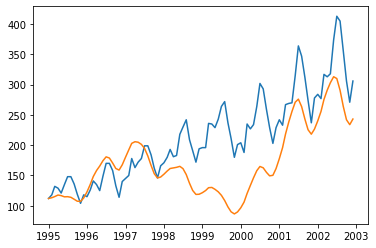

In [32]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedAirlines)
plt.plot(predictions_ARIMA)
plt.show()

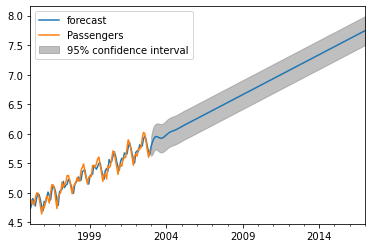

In [29]:
results_AR.plot_predict(1,264)
results = results_AR.forecast(steps = 100)

In [30]:
results[1]

array([0.08322789, 0.10433389, 0.10879246, 0.10879587, 0.11129808,
       0.11615922, 0.12024408, 0.12204269, 0.1222865 , 0.12234938,
       0.12286454, 0.12359406, 0.12410625, 0.1242817 , 0.12428978,
       0.12431921, 0.12441646, 0.1245226 , 0.12458257, 0.1245965 ,
       0.12459655, 0.12460567, 0.12462354, 0.12463909, 0.12464618,
       0.12464723, 0.12464741, 0.12464919, 0.12465174, 0.1246535 ,
       0.12465405, 0.12465406, 0.12465423, 0.12465471, 0.12465522,
       0.12465552, 0.12465562, 0.12465562, 0.12465563, 0.12465567,
       0.1246557 , 0.12465571, 0.12465571, 0.12465572, 0.12465574,
       0.12465577, 0.1246558 , 0.12465581, 0.12465582, 0.12465582,
       0.12465582, 0.12465582, 0.12465582, 0.12465583, 0.12465583,
       0.12465584, 0.12465585, 0.12465585, 0.12465586, 0.12465587,
       0.12465587, 0.12465587, 0.12465588, 0.12465588, 0.12465589,
       0.12465589, 0.1246559 , 0.1246559 , 0.12465591, 0.12465591,
       0.12465592, 0.12465592, 0.12465593, 0.12465593, 0.12465

In [31]:
len(results[1])


100